# 泰坦尼克号数据分析

## 1. 介绍

泰坦尼克号数据：包括泰坦尼克号上 2224 名乘客和船员中 891 名的人口学数据和乘客基本信息。你可以右键点击 [该链接](https://raw.githubusercontent.com/ShiChJ/DAND-Basic-Materials/master/P2/Project_Files/titanic-data.csv) 选择“另存为”下载。你也可以在 [Kaggle](https://www.kaggle.com/c/titanic/data) 网站上查看这个数据集的详细描述。这个数据集就是来自 Kaggle。

目的是根据数据集的内容，分析有哪些因素会提高船上人的生还率？


## 2. 设置报告

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numbers import Number
from scipy import stats

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 3 读取数据

In [3]:
#读取预览数据
titanic_df = pd.read_csv('titanic-data.csv')
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


## 4 处理冗余数据

### 4.1 初步分析原始数据


In [4]:
# 计算缺失的数据
titanic_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

原始数据在Age, Cabin, Embarked这三个值中有缺失的数据,

由于变量Cabin缺失太多，为了避免误差影响判断，去掉Cabin变量

下面对Age Embarked数据进行处理,并删除不必要的列

In [5]:
# 删除Cabin变量
titanic_df = titanic_df.drop('Cabin',axis=1)

### 4.2 缺失的年龄数据处理

关于缺失年龄变量的处理，采用根据性别和PClass两个因素来填补空缺的年龄

In [6]:
missing_ages = titanic_df[titanic_df['Age'].isnull()]
# 根据Sex和Pclass属性计算年龄均值
mean_ages = titanic_df.groupby(['Sex','Pclass'])['Age'].mean()

def remove_na_ages(row):
    '''
    如果年龄字段为空，则根据年龄的均值填充数据集
    '''
    if pd.isnull(row['Age']):
        return mean_ages[row['Sex'], row['Pclass']]
    else:
        return row['Age']
    
titanic_df['Age'] = titanic_df.apply(remove_na_ages, axis=1)
titanic_df.info()
titanic_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 76.6+ KB


PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       2
dtype: int64

### 4.3 缺失的出发港数据处理

In [8]:
missing_ports = titanic_df[titanic_df['Embarked'].isnull()]

# 查看Embarked的值的比例

titanic_df.groupby('Embarked').count()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare
Embarked,,,,,,,,,,
C,168,168,168,168,168,168,168,168,168,168
Q,77,77,77,77,77,77,77,77,77,77
S,644,644,644,644,644,644,644,644,644,644


Embarked 值的比例 C:Q:S = 168:77:644，且仅缺失2个值，所以赋予缺失的 Embarked 值 S

In [9]:
# 对缺失 Embarked 赋值 S

titanic_df['Embarked'].fillna('S', inplace=True)

### 4.4 删除不需要的列

In [10]:
# name Ticket在分析是不需要，直接删除
titanic_df = titanic_df.drop(['Name','Ticket'], axis=1)
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(2)
memory usage: 62.7+ KB


### 4.5 值转换

Survived->Boolean (1=True 0=False)

Embarked -> C=Cherbourg Q=Queestown S=Southampton


In [11]:
def map_data(df):
    survived_map = {0:False, 1:True}
    df['SurvivedLabel'] =df['Survived'].map(survived_map)
    
    sex_map = {'male':1, 'female':2}
    df['SexLabel'] = df['Sex'].map(sex_map)
    
    port_map = {'C':'Cherbourg', 'Q':'Queestown','S':'Southampton'}
    df['Embarked']=df['Embarked'].map(port_map)
    
    df['FamilySize'] =df['SibSp'] + df['Parch']
    
    return df

titanic_df = map_data(titanic_df)
titanic_df.head(6)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,SurvivedLabel,SexLabel,FamilySize
0,1,0,3,male,22.000000,1,0,7.2500,Southampton,False,1,1
1,2,1,1,female,38.000000,1,0,71.2833,Cherbourg,True,2,1
2,3,1,3,female,26.000000,0,0,7.9250,Southampton,True,2,0
3,4,1,1,female,35.000000,1,0,53.1000,Southampton,True,2,1
4,5,0,3,male,35.000000,0,0,8.0500,Southampton,False,1,0
5,6,0,3,male,26.507589,0,0,8.4583,Queestown,False,1,0


对年龄数据进行分组

In [12]:
age_labels = ['0-9','10-19', '20-29','30-39','40-49','50-59','60-69','70-79']
titanic_df['age_group'] = pd.cut(titanic_df.Age, range(0,81,10), right=False, labels=age_labels)

titanic_df.head(6)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,SurvivedLabel,SexLabel,FamilySize,age_group
0,1,0,3,male,22.000000,1,0,7.2500,Southampton,False,1,1,20-29
1,2,1,1,female,38.000000,1,0,71.2833,Cherbourg,True,2,1,30-39
2,3,1,3,female,26.000000,0,0,7.9250,Southampton,True,2,0,20-29
3,4,1,1,female,35.000000,1,0,53.1000,Southampton,True,2,1,30-39
4,5,0,3,male,35.000000,0,0,8.0500,Southampton,False,1,0,30-39
5,6,0,3,male,26.507589,0,0,8.4583,Queestown,False,1,0,20-29


In [13]:
titanic_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,SexLabel,FamilySize
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.318643,0.523008,0.381594,32.204208,1.352413,0.904602
std,257.353842,0.486592,0.836071,13.281103,1.102743,0.806057,49.693429,0.477990,1.613459
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,223.500000,0.000000,2.000000,21.750000,0.000000,0.000000,7.910400,1.000000,0.000000
50%,446.000000,0.000000,3.000000,26.507589,0.000000,0.000000,14.454200,1.000000,0.000000
75%,668.500000,1.000000,3.000000,36.000000,1.000000,0.000000,31.000000,2.000000,1.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,2.000000,10.000000


## 5. 分析数据

从三个方面分析

第一个性别

第二个舱室级别

第三个家庭成员


Text(0.5,1,'Sex and survived')

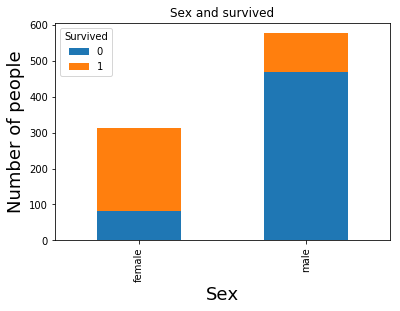

In [14]:
# 可视化性别生还数据
gp = titanic_df.groupby(["Sex","Survived"])["Survived"].count().unstack().plot(kind="bar",stacked="True")
plt.xlabel('Sex',fontsize=18)
plt.ylabel('Number of people',fontsize=18)
plt.title('Sex and survived')

根据上图分析结果

女性的幸存率高于男性

Text(0.5,1,'Ticket class and survived')

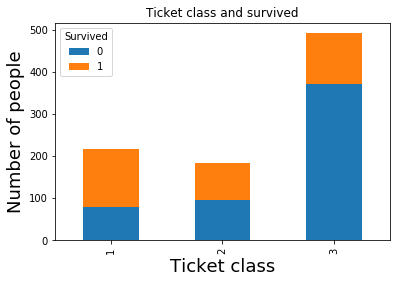

In [15]:
# 可视化船舱级别生还数据
gp = titanic_df.groupby(["Pclass","Survived"])["Survived"].count().unstack().plot(kind="bar",stacked="True")
plt.xlabel('Ticket class',fontsize=18)
plt.ylabel('Number of people',fontsize=18)
plt.title('Ticket class and survived')

船票的级别越高生存率越高（1st class代表高等舱 ）

Text(0.5,1,'FamilySize and survived')

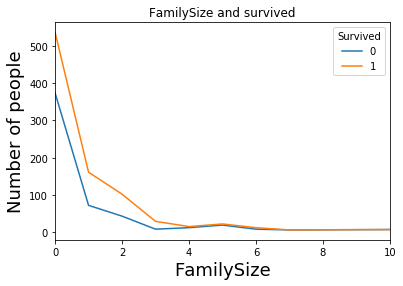

In [17]:
# 可视化家庭成员生还数据
gp = titanic_df.groupby(["FamilySize","Survived"])["Survived"].count().unstack().plot(kind="line",stacked="True")
plt.xlabel('FamilySize',fontsize=18)
plt.ylabel('Number of people',fontsize=18)
plt.title('FamilySize and survived')

家庭成员越少的生存几率越高

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


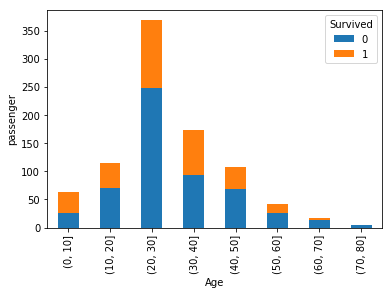

In [21]:
# 可视化不同年龄段的生还情况
Age_Survived = titanic_df[['Age','Survived']]
Age_Survived['i'] = pd.cut(Age_Survived['Age'], np.arange(0,100,10))
Age_Survived.groupby(['i','Survived'])['Survived'].count().unstack().plot(kind='bar',stacked=True)
plt.xlabel('Age')
plt.ylabel('passenger')
plt.show()

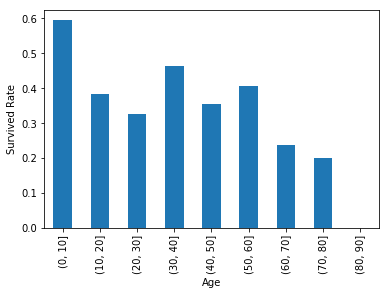

In [30]:
# 可视化不同年龄段生还概率
Age_Survived.groupby('i')['Survived'].mean().plot(kind='bar')
plt.xlabel('Age')
plt.ylabel('Survived Rate')
plt.show()

根据上图分析结果, 0~10岁的孩子生存几率最高

In [32]:
print('性别相关性：%s'%corrcoef(titanic_df['Survived'],titanic_df['SexLabel']))

print('船票级别相关性：%s'%corrcoef(titanic_df['Survived'],titanic_df['Pclass']))

print('家庭成员相关性：%s'%corrcoef(titanic_df['Survived'],titanic_df['FamilySize']))

print('年龄相关性：%s'%corrcoef(titanic_df['Survived'],titanic_df['Age']))


性别相关性：[[ 1.          0.54335138]
 [ 0.54335138  1.        ]]
船票级别相关性：[[ 1.         -0.33848104]
 [-0.33848104  1.        ]]
家庭成员相关性：[[ 1.          0.01663899]
 [ 0.01663899  1.        ]]
年龄相关性：[[ 1.         -0.06748498]
 [-0.06748498  1.        ]]


说明性别有正向相关性，女性高于男性（这里男性是1女性是2）

船票级别有相关性，程负相关，级别越低，幸存率越低

家庭成员数越小，生存率越高，相关性很小

年龄越小生存几率越高，但相关性很小

# 6. 总结

女性生存率高于男性

船票级别越高生还率越高

家庭成员越少生还率越高，但相关性很小

本次分析是基于此次数据的描述、统计和展现，不代表因果关系
因为Age变量进行了缺失赋值，可能影响结果误差
本次分析只分析了性别、船票级别和家庭成员三个因素，还有其他因素可能影响生还率